In [76]:
import numpy as np
import ot  # pip install POT
from sklearn.metrics import pairwise_distances
from soap import *
from sklearn.decomposition import PCA, NMF
from sklearn.kernel_approximation import RBFSampler


In [34]:
_, structure, species = read_cif("CIF_files/DB0-m1_o14_smb_repeat.cif")

In [35]:
soap_out, soap = S(structure = structure, species = species)

In [36]:
soap_out

array([[ 1.44527968e-04,  3.02603639e-05,  1.98339927e-03, ...,
        -2.23449409e-03,  6.80180872e+00,  4.96013516e-03],
       [ 2.98962645e-05,  2.04845632e-05,  6.67611037e-04, ...,
         5.44520471e-04,  6.70642019e+00,  3.75441117e-03],
       [ 6.76165758e-04,  3.74826567e-04,  3.15749809e-03, ...,
         1.13684853e-03,  6.70247714e+00,  3.69016430e-03],
       ...,
       [ 7.61647279e+00,  1.45995339e-02,  6.00068831e+00, ...,
         2.28852776e-04,  5.05061852e-06,  5.52786141e-06],
       [ 3.37711769e+00,  2.11066809e-01,  9.01868235e+00, ...,
         1.75493717e-05,  7.01850735e-08,  1.00265355e-07],
       [ 1.34471988e-01,  3.80896391e-02,  1.71903804e+00, ...,
         2.57604367e-04,  1.55579813e-06,  1.75955486e-06]])

In [48]:
# 1) Build the N_env × N_env kernel among environments.  
#    For example, use an RBF kernel with some gamma > 0.
def rbf_kernel(u, v, gamma=1e-3):
    diff = u - v
    return np.exp(-gamma * (diff @ diff))

N_env, N_feat = soap_out.shape

K = np.zeros((N_env, N_env))
for i in range(N_env):
    for j in range(N_env):
        K[i, j] = rbf_kernel(soap_out[i], soap_out[j], gamma=1e-3)

In [70]:
# 1) Ensure K is nonnegative (clip tiny numerical negatives):
K_nonneg = np.clip(K, a_min=0, a_max=None)  # shape = (N_env, N_env)

# 2) Fit NMF with rank=1:
nmf = NMF(n_components=1, init="nndsvda", random_state=0, max_iter=1000)
W = nmf.fit_transform(K_nonneg)  # shape = (N_env, 1)
w = W[:, 0]                      # shape = (N_env,)

# 3) Normalize so sum(w)=1:
w /= w.sum()

# 4) Collapse SOAP:
d_nmf = w.reshape(1, -1) @ soap_out  # shape = (1, N_feat)

print("NMF weights sum to:", w.sum())       # → 1.0
print("Descriptor shape:", d_nmf.shape)     # → (1, N_feat)

NMF weights sum to: 0.9999999999999999
Descriptor shape: (1, 20)


/home/mmm9886/.conda/envs/pyemma/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


In [74]:
# 1) Create a tiny‐noise copy of soap_out:
noise_level = 1e-5
soap_B = soap_out + noise_level * np.random.randn(N_env, N_feat)

# 2) Build squared‐Euclidean cost D between A=soap_out and B=soap_B:
D = pairwise_distances(soap_out, soap_B, metric="sqeuclidean")  # shape = (N_env, N_env)

# 3) Uniform marginals a,b ∈ ℝ^{N_env}:
a = np.ones(N_env) / N_env
b = np.ones(N_env) / N_env

# 4) Solve Sinkhorn OT on D → coupling P:
reg = 1e-2   # entropic regularization; increase if convergence fails
P = ot.sinkhorn(a, b, D, reg)  # shape = (N_env, N_env)

# 5) Extract row‐sums w and normalize:
w = P.sum(axis=1)      # shape = (N_env,)
w /= w.sum()

# 6) Collapse SOAP:
d_rematch = w.reshape(1, -1) @ soap_out  # shape = (1, N_feat)

print("Sinkhorn‐derived weights sum to:", w.sum())     # → 1.0
print("Descriptor shape:", d_rematch.shape)            # → (1, N_feat)

Sinkhorn‐derived weights sum to: 0.9999999999999999
Descriptor shape: (1, 20)


/home/mmm9886/.conda/envs/pyemma/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


In [79]:
# 1) Pick gamma and number of RFF dims D:
gamma = 1e-3
D = 500

# 2) Create RFF map and transform soap_out → Φ ∈ ℝ^{N_env×D}:
rbf_sampler = RBFSampler(gamma=gamma, n_components=D, random_state=0)
Phi = rbf_sampler.fit_transform(soap_out)  # shape = (N_env, D)

# 3) Run PCA on Φ to get k‐dim embedding:
k = 1
pca = PCA(n_components=k)
Z_rff = pca.fit_transform(Phi)  # shape = (N_env, k)

print("RFF→PCA embedding shape:", Z_rff.shape)  # (N_env, k)

RFF→PCA embedding shape: (213, 1)


In [80]:
Z_rff

array([[-0.49043983],
       [-0.49148631],
       [-0.49143244],
       [-0.49141139],
       [-0.50209674],
       [-0.4872954 ],
       [-0.48920468],
       [-0.49086873],
       [-0.4925143 ],
       [-0.48624388],
       [-0.49196919],
       [-0.48917913],
       [-0.4903114 ],
       [-0.49114386],
       [-0.48714728],
       [-0.490508  ],
       [-0.48911879],
       [-0.12904845],
       [-0.11384961],
       [-0.10147352],
       [-0.1065694 ],
       [-0.12008471],
       [-0.1403145 ],
       [-0.49073729],
       [-0.48983553],
       [-0.48699159],
       [-0.48991174],
       [-0.50210132],
       [-0.48549459],
       [-0.48429523],
       [-0.49962065],
       [-0.48910817],
       [-0.49964253],
       [-0.49119692],
       [-0.49061355],
       [-0.4899753 ],
       [-0.4873365 ],
       [-0.4881604 ],
       [-0.48929918],
       [-0.49260621],
       [-0.11077034],
       [-0.16986571],
       [-0.10216696],
       [-0.09533088],
       [-0.38454445],
       [-0

In [75]:
d_rematch

array([[ 2.77902631e+00,  5.32198372e-02,  4.11588378e+00,
        -5.19847926e-02,  1.63876232e-01, -2.68026443e-03,
         9.99165625e-03, -1.45617068e-03,  1.54767122e+01,
         3.17557746e-01,  1.59166562e+00, -1.56041520e-02,
         1.21731496e-01, -1.35054514e-02,  1.99147215e+00,
         2.26188261e-02,  4.92624250e-01,  2.93805103e-03,
         4.62426975e-01,  8.11873260e-03]])

In [71]:
d_diffusion

array([[ 2.90963190e+00,  5.52781133e-02,  4.26059148e+00,
        -5.40485349e-02,  1.68401592e-01, -2.93012785e-03,
         9.99051475e-03, -1.45741567e-03,  1.48899646e+01,
         3.30578670e-01,  1.62148234e+00, -1.67081085e-02,
         1.21255713e-01, -1.35203278e-02,  1.99201130e+00,
         2.32826044e-02,  4.70189395e-01,  3.04135999e-03,
         4.32615295e-01,  8.01986087e-03]])

In [72]:
d_nmf

array([[ 2.96605068e+00,  5.36428919e-02,  4.21906596e+00,
        -5.12281997e-02,  1.71846036e-01, -3.04827738e-03,
         1.03681232e-02, -1.51324392e-03,  1.42004841e+01,
         3.33932346e-01,  1.64383798e+00, -1.63817341e-02,
         1.25654259e-01, -1.40244686e-02,  2.06222750e+00,
         2.34902785e-02,  4.89804312e-01,  3.12160018e-03,
         4.51152865e-01,  8.34918920e-03]])

In [38]:
d_pca

array([[-5.35578879e-02,  2.63602511e-03,  9.00507748e-02,
        -4.34378379e-03, -4.61352299e-03,  1.40025876e-04,
        -6.17948785e-04,  9.27201535e-05,  9.85483197e-01,
        -2.99520879e-03, -3.48841123e-02, -6.80611190e-04,
        -7.44502038e-03,  8.39780025e-04, -1.17775624e-01,
        -2.74320159e-04, -3.66950680e-02, -1.17149262e-04,
        -3.60175111e-02, -5.67344098e-04]])

In [32]:
d_emd

array([[ 2.77902631e+00,  5.32198372e-02,  4.11588378e+00,
        -5.19847926e-02,  1.63876232e-01, -2.68026443e-03,
         9.99165625e-03, -1.45617068e-03,  1.54767122e+01,
         3.17557746e-01,  1.59166562e+00, -1.56041520e-02,
         1.21731496e-01, -1.35054514e-02,  1.99147215e+00,
         2.26188261e-02,  4.92624250e-01,  2.93805103e-03,
         4.62426975e-01,  8.11873260e-03]])

In [47]:
d_rematch

array([[ 2.77902631e+00,  5.32198372e-02,  4.11588378e+00,
        -5.19847926e-02,  1.63876232e-01, -2.68026443e-03,
         9.99165625e-03, -1.45617068e-03,  1.54767122e+01,
         3.17557746e-01,  1.59166562e+00, -1.56041520e-02,
         1.21731496e-01, -1.35054514e-02,  1.99147215e+00,
         2.26188261e-02,  4.92624250e-01,  2.93805103e-03,
         4.62426975e-01,  8.11873260e-03]])

In [15]:
d_rematch

array([[ 2.77902631e+00,  5.32198372e-02,  4.11588378e+00,
        -5.19847926e-02,  1.63876232e-01, -2.68026443e-03,
         9.99165625e-03, -1.45617068e-03,  1.54767122e+01,
         3.17557746e-01,  1.59166562e+00, -1.56041520e-02,
         1.21731496e-01, -1.35054514e-02,  1.99147215e+00,
         2.26188261e-02,  4.92624250e-01,  2.93805103e-03,
         4.62426975e-01,  8.11873260e-03]])

In [21]:
so

array([ 2.77902631e+00,  5.32198372e-02,  4.11588378e+00, -5.19847926e-02,
        1.63876232e-01, -2.68026443e-03,  9.99165625e-03, -1.45617068e-03,
        1.54767122e+01,  3.17557746e-01,  1.59166562e+00, -1.56041520e-02,
        1.21731496e-01, -1.35054514e-02,  1.99147215e+00,  2.26188261e-02,
        4.92624250e-01,  2.93805103e-03,  4.62426975e-01,  8.11873260e-03])

In [16]:
so,_ = S(structure = structure, species = species, average = "outer")
si,_ = S(structure = structure, species = species, average = "inner")

In [17]:
import numpy as np
import matplotlib.pyplot as plt

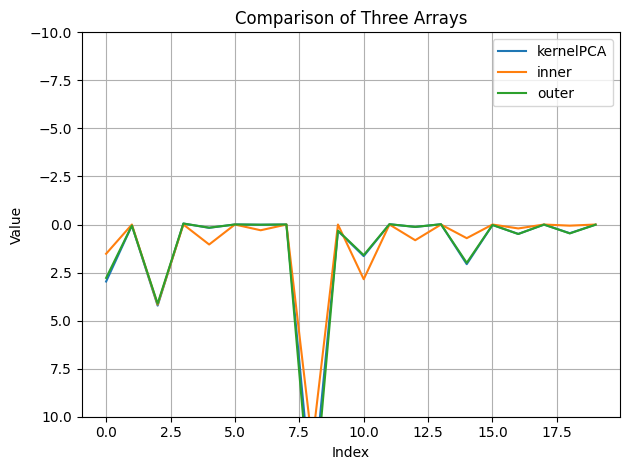

In [73]:
plt.plot(np.arange(20), d_nmf[0], label='kernelPCA')
plt.plot(np.arange(20), si, label='inner')
plt.plot(np.arange(20), so, label='outer')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Three Arrays')
plt.legend()
plt.ylim(10,-10)
plt.grid()
plt.tight_layout()
plt.show()